This Notebook illustrates the use of the the more advanced features of OpenMC's multi-group mode and the openmc.mgxs.Library class. During this process, this notebook will illustrate the following features:

   - Calculation of multi-group cross sections for a simplified BWR 8x8 assembly with isotropic and angle-dependent MGXS.
   - Automated creation and storage of MGXS with openmc.mgxs.Library
   - Fission rate comparison between continuous-energy and the two multi-group OpenMC cases.

To avoid focusing on unimportant details, the BWR assembly in this notebook is greatly simplified. The descriptions which follow will point out some areas of simplification.

# Generate Input Files

In [1]:
import os

from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np

import openmc

%matplotlib inline

We will be running a rodded 8x8 assembly with Gadolinia fuel pins. Lets create all the elemental data we would need for this case.

In [2]:
# Instantiate some elements
elements = {}
for elem in ['H', 'O', 'U', 'Zr', 'Gd', 'B', 'C', 'Fe']:
    elements[elem] = openmc.Element(elem)

With the elements we defined, we will now create the materials we will use later.

Material Definition Simplifications:

- This model will be run at room temperature so the NNDC ENDF-B/VII.1 data set can be used but the water density will be representative of a module with around 20% voiding. This water density will be non-physically used in all regions of the problem.
- Steel is composed of more than just iron, but we will only treat it as such here.


In [3]:
materials = {}

# Fuel
materials['Fuel'] = openmc.Material(name='Fuel')
materials['Fuel'].set_density('g/cm3', 10.32)
materials['Fuel'].add_element(elements['O'], 2)
materials['Fuel'].add_element(elements['U'], 1, enrichment=3.)

# Gadolinia bearing fuel
materials['Gad'] = openmc.Material(name='Gad')
materials['Gad'].set_density('g/cm3', 10.23)
materials['Gad'].add_element(elements['O'], 2)
materials['Gad'].add_element(elements['U'], 1, enrichment=3.)
materials['Gad'].add_element(elements['Gd'], .02)

# Zircaloy
materials['Zirc2'] = openmc.Material(name='Zirc2')
materials['Zirc2'].set_density('g/cm3', 6.55)
materials['Zirc2'].add_element(elements['Zr'], 1)

# Boiling Water
materials['Water'] = openmc.Material(name='Water')
materials['Water'].set_density('g/cm3', 0.6)
materials['Water'].add_element(elements['H'], 2)
materials['Water'].add_element(elements['O'], 1)

# Boron Carbide for the Control Rods
materials['B4C'] = openmc.Material(name='B4C')
materials['B4C'].set_density('g/cm3', 0.7 * 2.52)
materials['B4C'].add_element(elements['B'], 4)
materials['B4C'].add_element(elements['C'], 1)

# Steel 
materials['Steel'] = openmc.Material(name='Steel')
materials['Steel'].set_density('g/cm3', 7.75)
materials['Steel'].add_element(elements['Fe'], 1)

We can now create a Materials object that can be exported to an actual XML file.

In [4]:
# Instantiate a Materials object
materials_file = openmc.Materials(materials.values())

# Export to "materials.xml"
materials_file.export_to_xml()

Now let's move on to the geometry. The first step is to define some constants which will be used to set our dimensions and then we can start creating surfaces for the problem, the 8x8 lattice, the rods and the control blade.

Before proceeding lets discuss some simplifications made to the problem geometry:
- To enable the use of an equal-width mesh for running the multi-group calculations, the intra-assembly gap was increased to the same size as the pitch of the 8x8 fuel lattice
- The can is neglected
- The pin-in-water geometry for the control blade is ignored and instead the blade is a solid block of B4C
- Rounded corners are ignored
- There is no cladding for the water rod

In [5]:
# Set constants for the problem and assembly dimensions
fuel_rad = 0.53213
clad_rad = 0.61341
Np = 8
pin_pitch = 1.6256
length = float(Np + 2) * pin_pitch
rod_thick = 0.47752 / 2. + 0.14224
rod_span = 7. * pin_pitch

surfaces = {}

# Create boundary planes to surround the geometry
surfaces['Global x-'] = openmc.XPlane(x0=0., boundary_type='reflective')
surfaces['Global x+'] = openmc.XPlane(x0=length, boundary_type='reflective')
surfaces['Global y-'] = openmc.YPlane(y0=0., boundary_type='reflective')
surfaces['Global y+'] = openmc.YPlane(y0=length, boundary_type='reflective')

# Create planes to surround the 8x8 assembly
surfaces['Assembly x-'] = openmc.XPlane(x0=pin_pitch)
surfaces['Assembly x+'] = openmc.XPlane(x0=length - pin_pitch)
surfaces['Assembly y-'] = openmc.YPlane(y0=pin_pitch)
surfaces['Assembly y+'] = openmc.YPlane(y0=length - pin_pitch)

# Create cylinders for the fuel and clad
surfaces['Fuel Radius'] = openmc.ZCylinder(R=fuel_rad)
surfaces['Clad Radius'] = openmc.ZCylinder(R=clad_rad)

# Set surfaces for Control Rods
surfaces['Top Blade y-'] = openmc.YPlane(y0=length - rod_thick)
surfaces['Top Blade x-'] = openmc.XPlane(x0=pin_pitch)
surfaces['Top Blade x+'] = openmc.XPlane(x0=rod_span)
surfaces['Left Blade x+'] = openmc.XPlane(x0=rod_thick)
surfaces['Left Blade y-'] = openmc.YPlane(y0=length - rod_span)
surfaces['Left Blade y+'] = openmc.YPlane(y0=9. * pin_pitch)

With the surfaces defined, we can now construct half-spaces with these surfaces before we use those to create cells

In [6]:
# Set half-spaces for geometry building
half_spaces = {}
half_spaces['Global'] = \
    (+surfaces['Global x-'] & -surfaces['Global x+'] &
     +surfaces['Global y-'] & -surfaces['Global y+'])
half_spaces['Assembly'] = \
    (+surfaces['Assembly x-'] & -surfaces['Assembly x+'] &
     +surfaces['Assembly y-'] & -surfaces['Assembly y+'])
half_spaces['Fuel'] = -surfaces['Fuel Radius']
half_spaces['Clad'] = +surfaces['Fuel Radius'] & -surfaces['Clad Radius']
half_spaces['Pin Moderator'] = +surfaces['Clad Radius']
half_spaces['Top Blade'] = \
    (+surfaces['Top Blade y-'] & -surfaces['Global y+']) & \
    (+surfaces['Top Blade x-'] & -surfaces['Top Blade x+'])
half_spaces['Top Steel'] = \
    (+surfaces['Global x-'] & -surfaces['Top Blade x-']) & \
    (+surfaces['Top Blade y-'] & -surfaces['Global y+'])
half_spaces['Left Blade'] = \
    (+surfaces['Left Blade y-'] & -surfaces['Left Blade y+']) & \
    (+surfaces['Global x-'] & -surfaces['Left Blade x+'])
half_spaces['Left Steel'] = \
    (+surfaces['Left Blade y+'] & -surfaces['Top Blade y-']) & \
    (+surfaces['Global x-'] & -surfaces['Left Blade x+'])
half_spaces['Corner Blade'] = \
    half_spaces['Left Steel'] | half_spaces['Top Steel']
half_spaces['Water Fill'] = \
    half_spaces['Global'] & ~half_spaces['Assembly'] & \
    ~half_spaces['Top Blade'] & ~half_spaces['Left Blade'] &\
    ~half_spaces['Corner Blade']

We will begin building the 8x8 assembly. To do that we will have to build the cells and universe for each pin type (fuel, gadolinia-fuel, and water).

In [7]:
universes = {}
cells = {}

for name, mat, in zip(['Fuel Pin', 'Gd Pin'],
                      [materials['Fuel'], materials['Gad']]):
    universes[name] = openmc.Universe(name=name)
    cells[name] = openmc.Cell(name=name)
    cells[name].fill = mat
    cells[name].region = half_spaces['Fuel']
    universes[name].add_cell(cells[name])
    cells[name + ' Clad'] = openmc.Cell(name=name + ' Clad')
    cells[name + ' Clad'].fill = materials['Zirc2']
    cells[name + ' Clad'].region = half_spaces['Clad']
    universes[name].add_cell(cells[name + ' Clad'])
    cells[name + ' Water'] = openmc.Cell(name=name + ' Water')
    cells[name + ' Water'].fill = materials['Water']
    cells[name + ' Water'].region = half_spaces['Pin Moderator']
    universes[name].add_cell(cells[name + ' Water'])

universes['Hole'] = openmc.Universe(name='Hole')
cells['Hole'] = openmc.Cell(name='Hole')
cells['Hole'].fill = materials['Water']
universes['Hole'].add_cell(cells['Hole'])

Let's use this pin information to create our 8x8 assembly.

In [8]:
# Create fuel assembly Lattice
universes['Assembly'] = openmc.RectLattice(name='Assembly')
universes['Assembly'].pitch = (pin_pitch, pin_pitch)
universes['Assembly'].lower_left = [pin_pitch, pin_pitch]

f = universes['Fuel Pin']
g = universes['Gd Pin']
h = universes['Hole']

lattices = [[f, f, f, f, f, f, f, f],
            [f, f, f, f, f, f, f, f],
            [f, f, f, g, f, g, f, f],
            [f, f, g, h, h, f, g, f],
            [f, f, f, h, h, f, f, f],
            [f, f, g, f, f, f, g, f],
            [f, f, f, g, f, g, f, f],
            [f, f, f, f, f, f, f, f]]

# Store the array of lattice universes
universes['Assembly'].universes = lattices

cells['Assembly'] = openmc.Cell(name='Assembly')
cells['Assembly'].fill = universes['Assembly']
cells['Assembly'].region = half_spaces['Assembly']

So far we have the rods and water within the assembly , but we still need the control blade and the water which fills the rest of the space. We will create those cells now

In [9]:
# The top portion of the blade, poisoned with B4C
cells['Top Blade'] = openmc.Cell(name='Top Blade')
cells['Top Blade'].fill = materials['B4C']
cells['Top Blade'].region = half_spaces['Top Blade']

# The left portion of the blade, poisoned with B4C
cells['Left Blade'] = openmc.Cell(name='Left Blade')
cells['Left Blade'].fill = materials['B4C']
cells['Left Blade'].region = half_spaces['Left Blade']

# The top-left corner portion of the blade, with no poison
cells['Corner Blade'] = openmc.Cell(name='Corner Blade')
cells['Corner Blade'].fill = materials['Steel']
cells['Corner Blade'].region = half_spaces['Corner Blade']

# Water surrounding all other cells and our assembly
cells['Water Fill'] = openmc.Cell(name='Water Fill')
cells['Water Fill'].fill = materials['Water']
cells['Water Fill'].region = half_spaces['Water Fill']

OpenMC requires that there is a "root" universe. Let us create our root universe and fill it with the cells just defined.

In [10]:
# Create root Universe
universes['Root'] = openmc.Universe(name='root universe', universe_id=0)
universes['Root'].add_cells([cells['Assembly'], cells['Top Blade'],
                             cells['Corner Blade'], cells['Left Blade'],
                             cells['Water Fill']])

What do you do after you create your model? Check it! We will use the plotting capabilities of the Python API to do this for us.

When doing so, we will coloring by material with fuel being red, gadolinia-fuel as yellow, zirc cladding as a light grey, water as blue, B4C as black and steel as a darker gray.

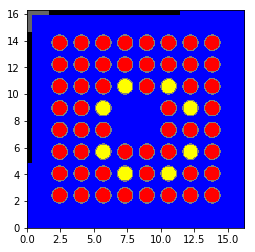

In [11]:
universes['Root'].plot(center=(length / 2., length / 2., 0.),
                       pixels=(500, 500), width=(length, length),
                       color_by='material',
                       colors={materials['Fuel']: (1., 0., 0.),
                               materials['Gad']: (1., 1., 0.),
                               materials['Zirc2']: (0.5, 0.5, 0.5),
                               materials['Water']: (0.0, 0.0, 1.0),
                               materials['B4C']: (0.0, 0.0, 0.0),
                               materials['Steel']: (0.4, 0.4, 0.4)})

Looks pretty good to us!

We now must create a geometry that is assigned a root universe and export it to XML.

In [12]:
# Create Geometry and set root Universe
geometry = openmc.Geometry()
geometry.root_universe = universes['Root']
# Export to "geometry.xml"
geometry.export_to_xml()

With the geometry and materials finished, we now just need to define simulation parameters, including how to run the model and what we want to learn from the model (i.e., define the tallies). We will start with our simulation parameters in the next block.

This will include setting the run strategy, telling OpenMC not to bother creating a `tallies.out` file, and limiting the verbosity of our output to just the header and results to not clog up our notebook with results from each batch.

In [13]:
# OpenMC simulation parameters
batches = 2000
inactive = 200
particles = 1000

# Instantiate a Settings object
settings_file = openmc.Settings()
settings_file.batches = batches
settings_file.inactive = inactive
settings_file.particles = particles
settings_file.output = {'tallies': False}
settings_file.verbosity = 4

# Create an initial uniform spatial source distribution over fissionable zones
bounds = [pin_pitch, pin_pitch, 10, length - pin_pitch, length - pin_pitch, 10]
uniform_dist = openmc.stats.Box(bounds[:3], bounds[3:], only_fissionable=True)
settings_file.source = openmc.source.Source(space=uniform_dist)

# Export to "settings.xml"
settings_file.export_to_xml()

# Create an MGXS Library

Now we are ready to generate multi-group cross sections! First, let's define a 2-group structure using the built-in EnergyGroups class.

In [14]:
# Instantiate a 2-group EnergyGroups object
groups = openmc.mgxs.EnergyGroups()
groups.group_edges = np.array([0., 0.625, 20.0e6])

Next, we will instantiate an openmc.mgxs.Library for the energy groups with our the problem geometry. This library will use the default setting of isotropically-weighting the multi-group cross sections.

In [15]:
# Initialize a 2-group Isotropic MGXS Library for OpenMC
iso_mgxs_lib = openmc.mgxs.Library(geometry)
iso_mgxs_lib.energy_groups = groups

Now, we must specify to the Library which types of cross sections to compute. OpenMC's multi-group mode can accept isotropic flux-weighted cross sections or angle-dependent cross sections, as well as supporting anisotropic scattering represented by either Legendre polynomials, histogram, or tabular angular distributions.  

Just like before, we will create the following multi-group cross sections needed to run an OpenMC simulation to verify the accuracy of our cross sections: "total", "absorption", "nu-fission", '"fission", "nu-scatter matrix", "multiplicity matrix", and "chi".
"multiplicity matrix" is needed to provide OpenMC's multi-group mode with additional information needed to accurately treat scattering multiplication (i.e., (n,xn) reactions)) explicitly.

In [16]:
# Specify multi-group cross section types to compute
iso_mgxs_lib.mgxs_types = ['total', 'absorption', 'nu-fission', 'fission',
                           'nu-scatter matrix', 'multiplicity matrix', 'chi']

Now we must specify the type of domain over which we would like the `Library` to compute multi-group cross sections. The domain type corresponds to the type of tally filter to be used in the tallies created to compute multi-group cross sections. At the present time, the `Library` supports "material" "cell", "universe", and "mesh" domain types. 

For the sake of example we will use a mesh to gather our cross sections. This mesh will be set up so there is one mesh bin for every pin cell.

In [17]:
# Instantiate a tally Mesh
mesh = openmc.Mesh()
mesh.type = 'regular'
mesh.dimension = [10, 10]
mesh.lower_left = [0., 0.]
mesh.upper_right = [length, length]

# Specify a "mesh" domain type for the cross section tally filters
iso_mgxs_lib.domain_type = "mesh"

# Specify the mesh over which to compute multi-group cross sections
iso_mgxs_lib.domains = [mesh]

Now we will set the scattering treatment that we wish to use.

In the `mg-mode-part-ii` notebook, the cross sections were generated with a typical P3 scattering expansion in mind. Now, however, we will use a more advanced technique: OpenMC will directly provide us a histogram of the change-in-angle (i.e., $\mu$) distribution.

Where as in the `mg-mode-part-ii` notebook, all that was required was to set the `legendre_order` attribute of `mgxs_lib`, here we have only slightly more work: we have to tell the Library that we want to use a histogram distribution (as it is not the default), and then tell it the number of bins.

For this problem we will use 11 bins.

In [18]:
# Set the scattering format to histogram and then define the number of bins

# Avoid a warning that corrections dont make sense with histogram data
iso_mgxs_lib.correction = None
# Set the histogram data
iso_mgxs_lib.scatter_format = 'histogram'
iso_mgxs_lib.histogram_bins = 11

Ok, we made our isotropic library with histogram-scattering!

Now why dont we go ahead and create a library to do the same, but with angle-dependent MGXS. That is, we will avoid making the isotropic flux weighting approximation and instead just store a cross section for every polar and azimuthal angle pair.

To do this with the Python API and OpenMC, all we have to do is set the number of polar and azimuthal bins. Here we only need to set the number of bins, the API will convert all of angular space into equal-width bins for us.

Since this problem is symmetric in the z-direction, we only need to concern ourselves with the azimuthal variation here.  We will use eight angles.

Ok, we will repeat all the above steps for a new library object, but will also set the number of azimuthal bins at the end.

In [19]:
# Lets repeat all of the above for an angular MGXS library so we can gather
# that in the same continuous-energy calculation
angle_mgxs_lib = openmc.mgxs.Library(geometry)
angle_mgxs_lib.energy_groups = groups
angle_mgxs_lib.mgxs_types = ['total', 'absorption', 'nu-fission', 'fission',
                             'nu-scatter matrix', 'multiplicity matrix', 'chi']

angle_mgxs_lib.domain_type = "mesh"
angle_mgxs_lib.domains = [mesh]
angle_mgxs_lib.correction = None
angle_mgxs_lib.scatter_format = 'histogram'
angle_mgxs_lib.histogram_bins = 11

# Set the angular bins to 8
angle_mgxs_lib.num_azimuthal = 8

Now that our libraries have been setup, lets make sure they contain the types of cross sections which meet the needs of OpenMC's multi-group solver.  Note that this step is done automatically when writing the Multi-Group Library file later in the process (as part of the `mgxs_lib.write_mg_library()`), but it is a good practice to also run this before spending all the time running OpenMC to generate the cross sections.

In [20]:
# Check the libraries - if no errors are raised, then the library is satisfactory.
iso_mgxs_lib.check_library_for_openmc_mgxs()
angle_mgxs_lib.check_library_for_openmc_mgxs()

Lastly, we use our two `Library` objects to construct the tallies needed to compute all of the requested multi-group cross sections in each domain.

We expect a warning here telling us that the default Legendre order is not meaningful since we are using histogram scattering.

In [21]:
# Construct all tallies needed for the multi-group cross section library
iso_mgxs_lib.build_library()
angle_mgxs_lib.build_library()

/home/nelsonag/git/openmc/openmc/mgxs/mgxs.py:3801: UserWarning: The legendre order will be ignored since the scatter format is set to histogram
  warnings.warn(msg)


The tallies within the libraries can now be exported to a "tallies.xml" input file for OpenMC.

In [22]:
# Create a "tallies.xml" file for the MGXS Library
tallies_file = openmc.Tallies()
iso_mgxs_lib.add_to_tallies_file(tallies_file, merge=True)
angle_mgxs_lib.add_to_tallies_file(tallies_file, merge=True)

In addition, we instantiate a fission rate mesh tally for eventual comparison of results.

In [23]:
# Instantiate tally Filter
mesh_filter = openmc.MeshFilter(mesh)

# Instantiate the Tally
tally = openmc.Tally(name='mesh tally')
tally.filters = [mesh_filter]
tally.scores = ['fission']

# Add tally to collection
tallies_file.append(tally, merge=True)

# Export all tallies to a "tallies.xml" file
tallies_file.export_to_xml()

Time to run the calculation and get our results!

In [24]:
# Run OpenMC
openmc.run()


                               %%%%%%%%%%%%%%%
                          %%%%%%%%%%%%%%%%%%%%%%%%
                       %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                     %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                  %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                   %%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                ###############      %%%%%%%%%%%%%%%%%%%%%%%%
               ##################     %%%%%%%%%%%%%%%%%%%%%%%
               ###################     %%%%%%%%%%%%%%%%%%%%%%%
               ####################     %%%%%%%%%%%%%%%%%%%%%%
               #####################     %%%%%%%%%%%%%%%%%%%%%
               ######################     %%%%%%%%%%%%%%%%%%%%
               #######################     %%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%

0

To make the files available and not be over-written when running the multi-group calculation, we will now rename the statepoint and summary files.

In [25]:
# Move the StatePoint File
ce_spfile = './ce_statepoint.h5'
os.rename('statepoint.' + str(batches) + '.h5', ce_spfile)
# Move the Summary file
ce_sumfile = './ce_summary.h5'
os.rename('summary.h5', ce_sumfile)

# Tally Data Processing

Our simulation ran successfully and created statepoint and summary output files.  Let's begin by loading the StatePoint file, but not automatically linking the summary file.

In [26]:
# Load the statepoint file, but not the summary file, as it is a different filename than expected.
sp = openmc.StatePoint(ce_spfile, autolink=False)

In addition to the statepoint file, our simulation also created a summary file which encapsulates information about the materials and geometry. This is necessary for the `openmc.Library` to properly process the tally data. We first create a `Summary` object and link it with the statepoint.  Normally this would not need to be performed, but since we have renamed our summary file to avoid conflicts with the Multi-Group calculation's summary file, we will load this in explicitly.

In [27]:
su = openmc.Summary(ce_sumfile)
sp.link_with_summary(su)

The statepoint is now ready to be analyzed. To create our libraries we simply have to load the tallies from the statepoint into each `Library` and our `MGXS` objects will compute the cross sections for us under-the-hood.

In [28]:
# Initialize MGXS Library with OpenMC statepoint data
iso_mgxs_lib.load_from_statepoint(sp)
angle_mgxs_lib.load_from_statepoint(sp)

The next step will be to prepare the input for OpenMC to use our newly created multi-group data.

# Isotropic Multi-Group OpenMC Calculation

We will now use the `Library` to produce the isotropic multi-group cross section data set for use by the OpenMC multi-group solver.  

If the model to be run in multi-group mode is the same as the continuous-energy mode, the `openmc.mgxs.Library` class has the ability to directly create the multi-group geometry, materials, and multi-group library for us. 
Note that this feature is only useful if the MG model is intended to replicate the CE geometry - it is not useful if the CE library is not the same geometry (like it would be for generating MGXS from a generic spectral region).

This method creates and assigns the materials automatically, including creating a geometry which is equivalent to our mesh cells for which the cross sections were derived.

In [29]:
# Allow the API to create our Library, materials, and geometry file
iso_mgxs_file, materials_file, geometry_file = iso_mgxs_lib.create_mg_mode()

# Tell the materials file what we want to call the multi-group library
materials_file.cross_sections = './mgxs.h5'

# Write our newly-created files to disk
iso_mgxs_file.export_to_hdf5('./mgxs.h5')
materials_file.export_to_xml()
geometry_file.export_to_xml()

/home/nelsonag/git/openmc/openmc/tallies.py:1835: RuntimeWarning: invalid value encountered in true_divide
  self_rel_err = data['self']['std. dev.'] / data['self']['mean']
/home/nelsonag/git/openmc/openmc/tallies.py:1836: RuntimeWarning: invalid value encountered in true_divide
  other_rel_err = data['other']['std. dev.'] / data['other']['mean']
/home/nelsonag/git/openmc/openmc/tallies.py:1837: RuntimeWarning: invalid value encountered in true_divide
  new_tally._mean = data['self']['mean'] / data['other']['mean']


Next, we can make the changes we need to the settings file.
These changes are limited to telling OpenMC to run a multi-group calculation and provide the location of our multi-group cross section file.

In [30]:
# Set the energy mode
settings_file.energy_mode = 'multi-group'

# Export to "settings.xml"
settings_file.export_to_xml()

Lets clear up the tallies file so it doesn't include all the extra tallies for re-generating a multi-group library

In [31]:
# Create a "tallies.xml" file for the MGXS Library
tallies_file = openmc.Tallies()

# Add our fission rate mesh tally
tallies_file.add_tally(tally)

# Export to "tallies.xml"
tallies_file.export_to_xml()

Before running the calculation let's look at our meshed model. It might not be interesting, but lets take a look anyways.

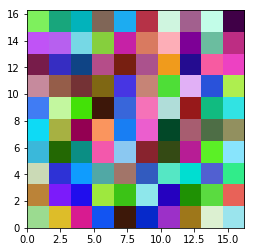

In [32]:
geometry_file.root_universe.plot(center=(length / 2., length / 2., 0.),
                       pixels=(300, 300), width=(length, length),
                       color_by='material')

So, we see a 10x10 grid with a different color for every material, sounds good!

At this point, the problem is set up and we can run the multi-group calculation.

In [33]:
# Execute the Isotropic MG OpenMC Run
openmc.run()


                               %%%%%%%%%%%%%%%
                          %%%%%%%%%%%%%%%%%%%%%%%%
                       %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                     %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                  %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                   %%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                ###############      %%%%%%%%%%%%%%%%%%%%%%%%
               ##################     %%%%%%%%%%%%%%%%%%%%%%%
               ###################     %%%%%%%%%%%%%%%%%%%%%%%
               ####################     %%%%%%%%%%%%%%%%%%%%%%
               #####################     %%%%%%%%%%%%%%%%%%%%%
               ######################     %%%%%%%%%%%%%%%%%%%%
               #######################     %%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%

0

Before we go the angle-dependent case, lets save the StatePoint and Summary files so they don't get over-written

In [34]:
# Move the StatePoint File
iso_mg_spfile = './iso_mg_statepoint.h5'
os.rename('statepoint.' + str(batches) + '.h5', iso_mg_spfile)
# Move the Summary file
iso_mg_sumfile = './iso_mg_summary.h5'
os.rename('summary.h5', iso_mg_sumfile)

# Angle-Dependent Multi-Group OpenMC Calculation

Lets now run the calculation with the angle-dependent multi-group cross sections. This process will be the exact same as above, except this time we will use the angle-dependent Library as our starting point.

We do not need to re-write the materials, geometry, or tallies file to disk since they are the same as for the isotropic case.

In [35]:
# Lets repeat for the angle-dependent case
angle_mgxs_lib.load_from_statepoint(sp)
angle_mgxs_file, materials_file, geometry_file = angle_mgxs_lib.create_mg_mode()
angle_mgxs_file.export_to_hdf5()

/home/nelsonag/git/openmc/openmc/tallies.py:1835: RuntimeWarning: invalid value encountered in true_divide
  self_rel_err = data['self']['std. dev.'] / data['self']['mean']
/home/nelsonag/git/openmc/openmc/tallies.py:1836: RuntimeWarning: invalid value encountered in true_divide
  other_rel_err = data['other']['std. dev.'] / data['other']['mean']
/home/nelsonag/git/openmc/openmc/tallies.py:1837: RuntimeWarning: invalid value encountered in true_divide
  new_tally._mean = data['self']['mean'] / data['other']['mean']


At this point, the problem is set up and we can run the multi-group calculation.

In [36]:
# Execute the angle-dependent OpenMC Run
openmc.run()


                               %%%%%%%%%%%%%%%
                          %%%%%%%%%%%%%%%%%%%%%%%%
                       %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                     %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                  %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                   %%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                ###############      %%%%%%%%%%%%%%%%%%%%%%%%
               ##################     %%%%%%%%%%%%%%%%%%%%%%%
               ###################     %%%%%%%%%%%%%%%%%%%%%%%
               ####################     %%%%%%%%%%%%%%%%%%%%%%
               #####################     %%%%%%%%%%%%%%%%%%%%%
               ######################     %%%%%%%%%%%%%%%%%%%%
               #######################     %%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%

0

# Results Comparison
In this section we will compare the eigenvalues and fission rate distributions of the continuous-energy, isotropic multi-group and angle-dependent multi-group cases.

We will begin by loading the multi-group statepoint files, first the isotropic, then angle-dependent. The angle-dependent was not renamed, so we can autolink its summary.

In [37]:
# Load the isotropic statepoint file
iso_mgsp = openmc.StatePoint(iso_mg_spfile, autolink=False)
iso_mgsum = openmc.Summary(iso_mg_sumfile)
iso_mgsp.link_with_summary(iso_mgsum)

# Load the angle-dependent statepoint file
angle_mgsp = openmc.StatePoint('statepoint.' + str(batches) + '.h5')

## Eigenvalue Comparison
Next, we can load the eigenvalues for comparison and do that comparison

In [38]:
ce_keff = sp.k_combined
iso_mg_keff = iso_mgsp.k_combined
angle_mg_keff = angle_mgsp.k_combined

# Find eigenvalue bias
iso_bias = 1.0E5 * (ce_keff[0] - iso_mg_keff[0])
angle_bias = 1.0E5 * (ce_keff[0] - angle_mg_keff[0])

Lets compare the eigenvalues in units of pcm

In [39]:
print('Isotropic to CE Bias [pcm]: {0:1.1f}'.format(iso_bias))
print('Angle to CE Bias [pcm]: {0:1.1f}'.format(angle_bias))

Isotropic to CE Bias [pcm]: 1406.5
Angle to CE Bias [pcm]: 173.8


We see a large reduction in error by switching to the usage of angle-dependent multi-group cross sections! 

Of course, this rodded and partially voided BWR problem was chosen specifically to exacerbate the angular variation of the reaction rates (and thus cross sections). Such improvements should not be expected in every case, especially if localized absorbers are not present.

It is important to note that both eigenvalues can be improved by the application of finer geometric or energetic discretizations, but this shows that the angle discretization may be a factor for consideration.

## Fission Rate Distribution Comparison
Next we will visualize the mesh tally results obtained from our three cases.

This will be performed by first obtaining the one-group fission rate tally information from our state point files. After we have this information we will re-shape the data to match the original mesh laydown. We will then normalize, and finally create side-by-side plots of all.

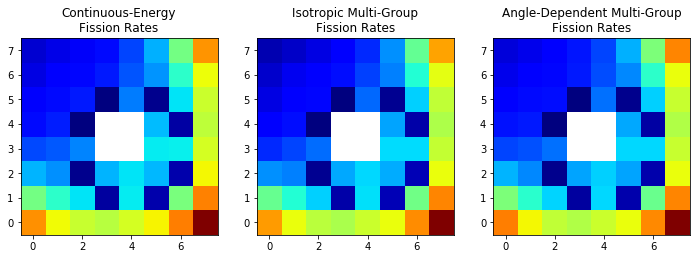

In [40]:
sp_files = [sp, iso_mgsp, angle_mgsp]
titles = ['Continuous-Energy', 'Isotropic Multi-Group',
         'Angle-Dependent Multi-Group']
fiss_rates = []
fig = plt.figure(figsize=(12, 6))
for i, (case, title) in enumerate(zip(sp_files, titles)):
    # Get our mesh tally information
    mesh_tally = case.get_tally(name='mesh tally')
    fiss_rates.append(mesh_tally.get_values(scores=['fission']))
    
    # Reshape the array
    fiss_rates[-1].shape = mesh.dimension
    
    # Normalize the fission rates
    fiss_rates[-1] /= np.mean(fiss_rates[-1])
    
    # Set 0s to NaNs so they show as white
    fiss_rates[-1][fiss_rates[-1] == 0.] = np.nan

    fig = plt.subplot(1, len(titles), i + 1)
    # Plot only the fueled regions
    plt.imshow(fiss_rates[-1][1:-1, 1:-1], cmap='jet',
               origin='lower')
    plt.title(title + '\nFission Rates')

With this colormap, dark blue is the lowest power and dark red is the highest power.

We see general agreement between the fission rate distributions, but it is evident that the continuous-energy and angle-dependent cases have less of a gradient near the rods than does the isotropic case (see the top left of each grid). This sort of effect is likely the culprit behind the large eigenvalue differences.